[INFO] Device: cuda
 Removing 422 rows with labels in EXCLUDE_LABELS: ['pray']
 Samples: 882097 | Labels: 6 -> ['anger', 'fear', 'happy', 'neutral', 'ps', 'sad']
 Showing a sample before/after preprocessing:

[Sample - raw text]
 @tiffanylue i know  i was listenin to bad habit earlier and i started freakin at his part =[

[Sample - tokens (truncated)]
[CLS] @ ti ##ffa ##ny ##lue i know i was listen ##in to bad hab ##it earlier and i started fr ##eak ##in at his part = [ [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


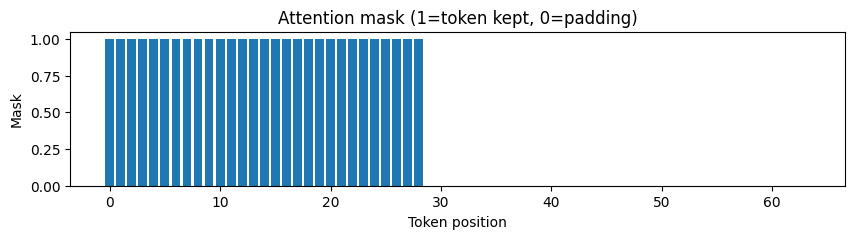

C:\Users\Administrator\AppData\Local\Temp\ipykernel_15816\1418775406.py:373: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15816\1418775406.py:229: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


 Starting training...


Epoch 1/4 → Train Acc: 82.80% | Val Acc: 94.75%
 Best model saved (Val Acc 94.75%) -> K:\Code\Project\Research Paper\Emotion Detection\Code\cnn_emotion_text_final.pth


Epoch 2/4 → Train Acc: 95.13% | Val Acc: 95.77%
 Best model saved (Val Acc 95.77%) -> K:\Code\Project\Research Paper\Emotion Detection\Code\cnn_emotion_text_final.pth


Epoch 3/4 → Train Acc: 95.69% | Val Acc: 96.00%
 Best model saved (Val Acc 96.00%) -> K:\Code\Project\Research Paper\Emotion Detection\Code\cnn_emotion_text_final.pth


Epoch 4/4 → Train Acc: 95.85% | Val Acc: 96.08%
 Best model saved (Val Acc 96.08%) -> K:\Code\Project\Research Paper\Emotion Detection\Code\cnn_emotion_text_final.pth
[INFO] Training finished in 35.46 minutes.


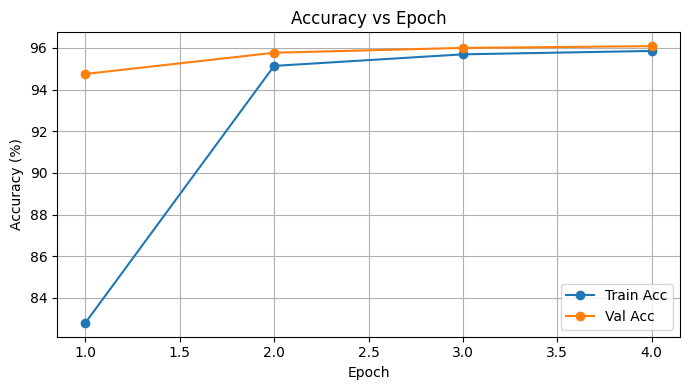

 Loaded best model (epoch 4, val acc 96.08%)


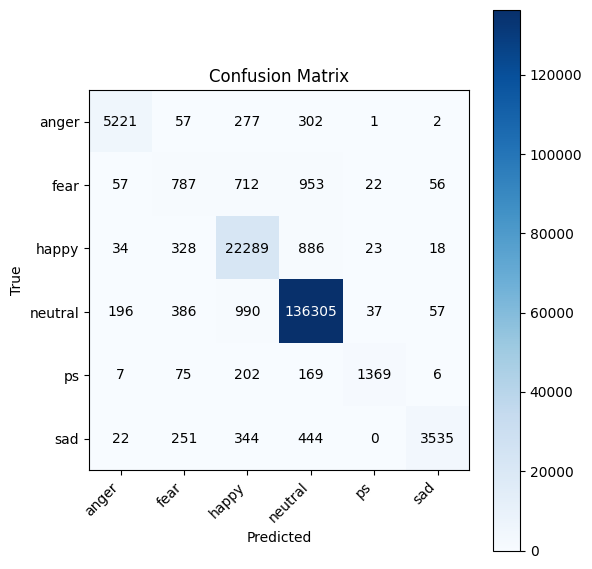

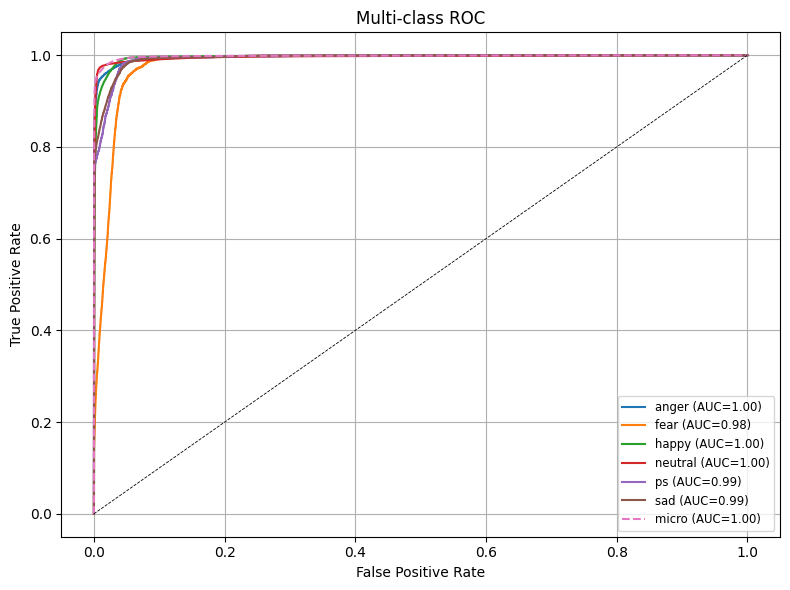

[DONE]

📊 Final Validation Metrics:
  • Precision : 0.8574
  • Recall    : 0.7744
  • F1-Score  : 0.8105


In [1]:


import os
import time
import random
from typing import List, Tuple
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


from transformers import BertTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, roc_curve, auc
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

# ------------------------
# USER CONFIG (edit paths & hyperparams)
# ------------------------
CSV_PATHS = [
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\tweet_emotions.csv",
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset2.csv",
    r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset3_excel.csv"
]

TOKENIZER_NAME = "bert-base-multilingual-cased"
MAX_LEN = 64
BATCH_SIZE = 32
EPOCHS = 4          
LR = 2e-5
WEIGHT_DECAY = 1e-2
WARMUP_RATIO = 0.1
NUM_WORKERS = 0     
PIN_MEMORY = True
RANDOM_SEED = 42

BEST_MODEL_PATH = r"K:\Code\Project\Research Paper\Emotion Detection\Code\cnn_emotion_text_final.pth"
LABELS_NPY = r"K:\Code\Project\Research Paper\Emotion Detection\Code\label_classes.npy"


EXCLUDE_LABELS: List[str] = ['pray']  # set ['pray'] if you want to drop that class

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] Device: {DEVICE}")

# CNN-specific hyperparams
EMBEDDING_DIM = 300
NUM_FILTERS = 100      # number of output channels per kernel size
KERNEL_SIZES = [3, 4, 5]
DROPOUT = 0.5


random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.benchmark = True

# ------------------------
# 1) Load & prepare CSVs
# ------------------------
def load_csvs(paths: List[str]) -> pd.DataFrame:
    dfs = []
    for p in paths:
        if os.path.exists(p):
            dfs.append(pd.read_csv(p))
        else:
            print(f"[WARN] CSV missing, skipping: {p}")
    if not dfs:
        raise RuntimeError("No CSV files found. Update CSV_PATHS.")
    df = pd.concat(dfs, ignore_index=True)
    if "content" not in df.columns or "sentiment" not in df.columns:
        raise RuntimeError("CSV files must contain columns 'content' and 'sentiment'.")
    df = df.dropna(subset=["content", "sentiment"])
    df["content"] = df["content"].astype(str).str.strip()
    df = df[df["content"] != ""]
    
    if EXCLUDE_LABELS:
        mask = ~df["sentiment"].astype(str).str.lower().isin([l.lower() for l in EXCLUDE_LABELS])
        removed = len(df) - mask.sum()
        print(f" Removing {removed} rows with labels in EXCLUDE_LABELS: {EXCLUDE_LABELS}")
        df = df[mask]
    return df

# ------------------------
# 2) Tokenizer and Dataset
# ------------------------
tokenizer = BertTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)

class SimpleTextDataset(Dataset):
    def __init__(self, texts: List[str], labels: List[int], tokenizer, max_len: int):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        txt = self.texts[idx]
        enc = self.tokenizer(txt, padding="max_length", truncation=True, max_length=self.max_len, return_tensors="pt")
        
        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long)
        }

# ------------------------
# 3) Model: TextCNN
# ------------------------
class TextCNNClassifier(nn.Module):
    def __init__(self, vocab_size: int, num_classes: int,
                 embedding_dim: int = EMBEDDING_DIM,
                 num_filters: int = NUM_FILTERS,
                 kernel_sizes: List[int] = KERNEL_SIZES,
                 dropout: float = DROPOUT,
                 padding_idx: int = 0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=padding_idx)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=num_filters, kernel_size=(k, embedding_dim))
            for k in kernel_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

        
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.1)
        for conv in self.convs:
            nn.init.kaiming_uniform_(conv.weight, nonlinearity='relu')

    def forward(self, input_ids, attention_mask=None):
        """
        input_ids: (batch, seq_len)
        attention_mask: unused here (kept for API parity with BERT model)
        """
        
        x = self.embedding(input_ids)
        
        x = x.unsqueeze(1)
        
        conv_outs = [F.relu(conv(x)).squeeze(3) for conv in self.convs]
        
        pooled = [F.max_pool1d(c, kernel_size=c.size(2)).squeeze(2) for c in conv_outs]
        cat = torch.cat(pooled, dim=1)  
        out = self.dropout(cat)
        logits = self.fc(out)
        return logits

# ------------------------
# 4) Sample-before/after visualization
# ------------------------
def show_sample_preprocessing(text: str):
    """Print raw text and show tokens + attention mask visualization."""
    print("\n[Sample - raw text]\n", text)
    enc = tokenizer(text, padding="max_length", truncation=True, max_length=MAX_LEN)
    tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"])
    attn = enc["attention_mask"]
    
    print("\n[Sample - tokens (truncated)]")
    print(" ".join(tokens[:MAX_LEN]))
    
    plt.figure(figsize=(10,2))
    plt.title("Attention mask (1=token kept, 0=padding)")
    plt.bar(range(len(attn)), attn)
    plt.xlabel("Token position")
    plt.ylabel("Mask")
    plt.show()

# ------------------------
# 5) Metrics & plotting (unchanged)
# ------------------------
def plot_accuracy(train_accs: List[float], val_accs: List[float]):
    epochs = range(1, len(train_accs)+1)
    plt.figure(figsize=(7,4))
    plt.plot(epochs, train_accs, marker='o', label="Train Acc")
    plt.plot(epochs, val_accs, marker='o', label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy vs Epoch")
    plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

def plot_confusion(cm, class_names):
    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=range(len(class_names)), yticks=range(len(class_names)),
           xticklabels=class_names, yticklabels=class_names,
           xlabel='Predicted', ylabel='True', title='Confusion Matrix')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i,j], 'd'), ha='center', va='center',
                    color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout(); plt.show()

def plot_multiclass_roc(y_true, y_score, class_names):
    try:
        y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))
        plt.figure(figsize=(8,6))
        for i in range(y_true_bin.shape[1]):
            fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC={roc_auc:.2f})")
        
        fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
        plt.plot(fpr, tpr, label=f"micro (AUC={auc(fpr,tpr):.2f})", linestyle='--')
        plt.plot([0,1],[0,1],'k--', linewidth=0.6)
        plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("Multi-class ROC")
        plt.legend(fontsize='small', loc='lower right'); plt.grid(True); plt.tight_layout(); plt.show()
    except Exception as e:
        print(" ROC plotting failed (maybe missing classes in validation):", e)

# ------------------------
# 6) Training loop 
# ------------------------
def train_loop(model, train_loader, val_loader, optimizer, scheduler, criterion, device, epochs, save_path):
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
    best_val_acc = -1.0
    best_state = None
    train_accs, val_accs = [], []

    for epoch in range(1, epochs+1):
        model.train()
        running_correct = 0
        running_total = 0
        running_loss = 0.0

        pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} train", leave=False)
        for batch in pbar:
            input_ids = batch["input_ids"].to(device, non_blocking=True)
            attention_mask = batch["attention_mask"].to(device, non_blocking=True)
            labels = batch["labels"].to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            with torch.amp.autocast('cuda',enabled=scaler.is_enabled()):
                logits = model(input_ids, attention_mask)
                loss = criterion(logits, labels)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            if scheduler is not None:
                scheduler.step()

            preds = logits.argmax(dim=1)
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
            running_loss += loss.item() * labels.size(0)

            train_acc = 100.0 * running_correct / running_total
            avg_loss = running_loss / running_total
            pbar.set_postfix({"Loss": f"{avg_loss:.4f}", "TrainAcc": f"{train_acc:.2f}%"})

        epoch_train_acc = 100.0 * running_correct / running_total
        train_accs.append(epoch_train_acc)

        # Validation: collect probs & targets
        model.eval()
        v_total = 0
        v_correct = 0
        all_probs = []
        all_targets = []
        with torch.no_grad(), torch.amp.autocast('cuda',enabled=scaler.is_enabled()):
            for batch in val_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                out = model(input_ids, attention_mask)
                probs = nn.functional.softmax(out, dim=1)
                preds = probs.argmax(dim=1)
                v_total += labels.size(0)
                v_correct += (preds == labels).sum().item()
                all_probs.append(probs.cpu().numpy())
                all_targets.append(labels.cpu().numpy())

        epoch_val_acc = 100.0 * v_correct / v_total if v_total > 0 else 0.0
        val_accs.append(epoch_val_acc)
        print(f"Epoch {epoch}/{epochs} → Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

        # Save best
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_state = {
                "epoch": epoch,
                "model_state": copy.deepcopy(model.state_dict()),
                "optimizer_state": optimizer.state_dict(),
                "val_acc": best_val_acc
            }
            # also save label classes separately (caller should save labels array)
            torch.save(best_state["model_state"], save_path)
            print(f" Best model saved (Val Acc {best_val_acc:.2f}%) -> {save_path}")

    # prepare final val arrays for plotting
    y_score = np.vstack(all_probs) if all_probs else np.array([])
    y_true = np.concatenate(all_targets) if all_targets else np.array([])

    return {
        "train_accs": train_accs,
        "val_accs": val_accs,
        "best_state": best_state,
        "y_true": y_true,
        "y_score": y_score
    }

# ------------------------
# 7) Main
# ------------------------
def main():
    df = load_csvs(CSV_PATHS)

    # label encode
    le = LabelEncoder()
    df["label"] = le.fit_transform(df["sentiment"].astype(str))
    texts = df["content"].tolist()
    labels = df["label"].tolist()
    class_names = list(le.classes_)
    print(f" Samples: {len(texts)} | Labels: {len(class_names)} -> {class_names}")

    # save label classes
    os.makedirs(os.path.dirname(LABELS_NPY), exist_ok=True)
    np.save(LABELS_NPY, class_names)

    # show one sample before/after preprocessing
    if len(texts) > 0:
        print(" Showing a sample before/after preprocessing:")
        show_sample_preprocessing(texts[0])

    # split (stratified)
    idxs = list(range(len(texts)))
    train_idx, val_idx = train_test_split(idxs, test_size=0.2, random_state=RANDOM_SEED, stratify=labels)

    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    train_ds = SimpleTextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
    val_ds = SimpleTextDataset(val_texts, val_labels, tokenizer, MAX_LEN)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    # model
    vocab_size = tokenizer.vocab_size
    pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else 0
    model = TextCNNClassifier(vocab_size=vocab_size, num_classes=len(class_names),
                              embedding_dim=EMBEDDING_DIM, num_filters=NUM_FILTERS,
                              kernel_sizes=KERNEL_SIZES, dropout=DROPOUT,
                              padding_idx=pad_token_id).to(DEVICE)

    optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    total_steps = len(train_loader) * EPOCHS
    warmup_steps = int(WARMUP_RATIO * total_steps) if total_steps > 0 else 0
    scheduler = get_linear_schedule_with_warmup(optimizer, warmup_steps, total_steps) if total_steps > 0 else None
    criterion = nn.CrossEntropyLoss()
    scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE.type == "cuda"))

    # load or train choice
    choice = input("Load saved model? (yes/no): ").strip().lower()
    if choice == "yes" and os.path.exists(BEST_MODEL_PATH):
        print(" Loading saved model from", BEST_MODEL_PATH)
        st = torch.load(BEST_MODEL_PATH, map_location=DEVICE)
        model.load_state_dict(st)
        model.to(DEVICE)
        # Evaluate
        model.eval()
        all_probs, all_targets = [], []
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch["input_ids"].to(DEVICE)
                attention_mask = batch["attention_mask"].to(DEVICE)
                out = model(input_ids, attention_mask)
                probs = nn.functional.softmax(out, dim=1).cpu().numpy()
                all_probs.append(probs); all_targets.append(batch["labels"].numpy())
        if all_probs:
            y_score = np.vstack(all_probs)
            y_true = np.concatenate(all_targets)
            cm = confusion_matrix(y_true, y_score.argmax(axis=1), labels=list(range(len(class_names))))
            plot_confusion(cm, class_names)
            plot_multiclass_roc(y_true, y_score, class_names)
        else:
            print(" No validation data to evaluate.")
        return

    # else train
    print(" Starting training...")
    t0 = time.time()
    stats = train_loop(model, train_loader, val_loader, optimizer, scheduler, criterion, DEVICE, EPOCHS, BEST_MODEL_PATH)
    print(f"[INFO] Training finished in {(time.time()-t0)/60:.2f} minutes.")
    plot_accuracy(stats["train_accs"], stats["val_accs"])

    # load best model if saved
    if stats["best_state"] is not None:
        model.load_state_dict(stats["best_state"]["model_state"])
        print(f" Loaded best model (epoch {stats['best_state']['epoch']}, val acc {stats['best_state']['val_acc']:.2f}%)")

    # final confusion & ROC
    if stats["y_score"].size != 0:
        cm = confusion_matrix(stats["y_true"], stats["y_score"].argmax(axis=1), labels=list(range(len(class_names))))
        plot_confusion(cm, class_names)
        plot_multiclass_roc(stats["y_true"], stats["y_score"], class_names)
    else:
        print(" No validation predictions available for plotting.")

    print("[DONE]")
    # --------------------------
    # ✅ Final Precision/Recall/F1
    # --------------------------
    if stats["y_score"].size != 0:
        y_true = stats["y_true"]
        y_pred = stats["y_score"].argmax(axis=1)

        precision = precision_score(y_true, y_pred, average="macro", zero_division=0)
        recall = recall_score(y_true, y_pred, average="macro", zero_division=0)
        f1 = f1_score(y_true, y_pred, average="macro", zero_division=0)

        print("\n📊 Final Validation Metrics:")
        print(f"  • Precision : {precision:.4f}")
        print(f"  • Recall    : {recall:.4f}")
        print(f"  • F1-Score  : {f1:.4f}")
    else:
        print(" No validation predictions available for final metrics.")


if __name__ == "__main__":
    main()


In [29]:
import pandas as pd
import chardet

filename = r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset3.csv"

# Detect encoding (open in binary mode 'rb')
with open(filename, "rb") as f:
    result = chardet.detect(f.read(50000))  # read first 50KB
    print("Detected encoding:", result)

# Load CSV using detected encoding
df = pd.read_csv(filename, encoding=result["encoding"])
print(df.head())

import pandas as pd
print("Trying UTF-8 encoding...")
df = pd.read_csv(filename, encoding="utf-8")
print(df.head())
df.to_csv(r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\dataset3_excel.csv",
          index=False, encoding="utf-8-sig")

Detected encoding: {'encoding': 'utf-8', 'confidence': 0.99, 'language': ''}
                                             Comment Emotion
0                     আমার প্রিয় অনেক পছন্দের মানুষ   Happy
1                          অনেক সুন্দর একটা কথা বলছি   Happy
2  মারাত্মক একজন জ্ঞানী এবং খুবই ভালো মানুষ ছিলেন...   Happy
3                                    ভালো মনের মানুষ   Happy
4                       অনেক ধন্যবাদ আপনাকে ভালোবাসা   Happy
Trying UTF-8 encoding...
                                             Comment Emotion
0                     আমার প্রিয় অনেক পছন্দের মানুষ   Happy
1                          অনেক সুন্দর একটা কথা বলছি   Happy
2  মারাত্মক একজন জ্ঞানী এবং খুবই ভালো মানুষ ছিলেন...   Happy
3                                    ভালো মনের মানুষ   Happy
4                       অনেক ধন্যবাদ আপনাকে ভালোবাসা   Happy


In [ ]:
df = pd.read_csv(r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\tweet_emotions.csv")

In [2]:
import pandas as pd

# Load your CSV
csv_path = r"K:\Code\Project\Research Paper\Emotion Detection\archive_text\tweet_emotions.csv"  # change if needed
df = pd.read_csv(csv_path)

# Drop missing values if any
df = df.dropna(subset=["sentiment"])

# Show unique emotions
print("🎭 Unique Emotions:")
print(df["sentiment"].unique())

# Show count of each emotion
print("\n📊 Emotion Counts:")
print(df["sentiment"].value_counts())


🎭 Unique Emotions:
['neutral' 'sad' 'happy' 'fear' 'ps' 'anger']

📊 Emotion Counts:
sentiment
happy      13112
neutral     9644
fear        8459
sad         5165
ps          2187
anger       1433
Name: count, dtype: int64
